# <span style="font-family:Times New Roman">Code 2. Набор 2.1.</span> 

Импортируем необходимые библиотеки

In [1]:
import pandas as pd
import numpy as np
import pickle
import time

import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, accuracy_score, f1_score, recall_score, precision_score

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, LSTM, Dropout

from get_features import get_song_features_set_1

Импортируем стиль визуализации из файла `custom_mplstyle.txt`

In [2]:
plt.style.use('ExtraData\\custom_mplstyle.txt')

In [ ]:
%%javascript
IPython.notebook.kernel.execute('file_name = "' + IPython.notebook.notebook_name + '"')

Импортируем необходимые списки

In [3]:
with open('genre_names.txt', 'r') as f:
    genre_names = f.read().split(';')

In [4]:
with open('genre_names_rus.txt', 'r') as f:
    genre_names_rus = f.read().split(';')

In [5]:
with open('genre_codes.pkl', 'rb') as f:
    genre_codes = pickle.load(f)

## <span style="font-family:Times New Roman">Описание набора данных:</span> 
#### 22 параметра, 3 деления, 3000 аудиофайлов по 10 секунд, shape = (3000, 22)</span> 

|   №  |       Параметр      ||   №  |    Параметр   |
|------|---------------------||------|---------------|
|**1** |centroid $mean$      ||**12**|mfcc$_1$ $mean$|
|**2** |centroid $std$       ||**13**|mfcc$_1$ $std$ |
|**3** |rolloff $mean$       ||**14**|mfcc$_2$ $mean$|
|**4** |rolloff $std$        ||**15**|mfcc$_2$ $std$ |
|**5** |bandwidth $mean$     ||**16**|mfcc$_3$ $mean$|
|**6** |bandwidth $std$      ||**17**|mfcc$_3$ $std$ |
|**7** |flux $mean$          ||**18**|mfcc$_4$ $mean$|
|**8** |flux $std$           ||**19**|mfcc$_4$ $std$ |
|**9** |zero crossings $mean$||**20**|mfcc$_5$ $mean$|
|**10**|zero crossings $std$ ||**21**|mfcc$_5$ $std$ |
|**11**|low energy           ||**22**|tempo          |







## <span style="font-family:Times New Roman">Используемые функции:</span> 

**1\.** `confusion_martix_plot` – график матрицы ошибок

Визуализируем матрицу ошибок, которая показывает производительность модели

In [6]:
def confusion_martix_plot(test, pred, acc, model_type):
    cm = confusion_matrix(test, pred)

    fig, axes = plt.subplots(1, 1, figsize=(10,7))
    fig.patch.set_facecolor('#371d49')
    
    sns.heatmap(cm,
                linewidths=.5,
                linecolor="black",
                cmap=plt.cm.RdPu_r,
                annot=True, 
                annot_kws={'fontsize':18},
                xticklabels=genre_names,
                yticklabels=genre_names)
    
    plt.title(f'Accuracy = {acc:.2f}', fontsize=22, y=1.05)
    plt.xlabel('Predicted', fontsize=18)
    plt.ylabel('Real', fontsize=18)
    
    fn = file_name.split('.')[0].replace(' ', '_').lower()
    lt = '_'.join(str(x) for x in list(time.localtime())[1:-3])
    plt.savefig(f'Images/cm_{fn}_{model_type}_{lt}.png', facecolor='#371d49', bbox_inches = 'tight', dpi = 300)
    plt.show()

**2\.** `plot_performance` – график обучения модели

Визуализируем изменение `accuracy` и `loss` значений в процессе обучения модели

In [7]:
def performance_plot(hist, save=False):

    acc = hist.history['acc']
    val_acc = hist.history['val_acc']
    loss = hist.history['loss']
    val_loss = hist.history['val_loss']
    epochs = range(len(acc))
    
    fig, axes = plt.subplots(ncols=2, figsize=(12, 4))
    
    line_1 = axes[0].plot(epochs, acc, '#18c0c4', label='Training accuracy')
    line_2 = axes[0].plot(epochs, val_acc, '#fefeff', label='Validation accuracy')
    axes[0].set_title('Training and validation accuracy')

    line_3 = axes[1].plot(epochs, loss, '#A267F5', label='Training Loss')
    line_4 = axes[1].plot(epochs, val_loss, '#f62196', label='Validation Loss')
    axes[1].set_title('Training and validation loss')

    lines = line_1 + line_2 + line_3 + line_4
    labs = [l.get_label() for l in lines]
    plt.legend(lines, labs, loc='center', bbox_to_anchor=(1.2, 0.5))
    lt = '_'.join(str(x) for x in list(time.localtime())[1:-3])
    if save:
        plt.savefig(f'Images/performance_{lt}.png', facecolor='#371d49', bbox_inches = 'tight', dpi = 300)
    plt.show()

**3\.** `prepare_datasets` – предобработка данных

С помощью `sklearn.model_selection.train_test_split` разделяем данные в два этапа: на `train` – `validation` выборки и на `train` – `test` выборки. Также, приводим данные в трёхмерную форму:

In [8]:
def prepare_datasets(X, Y, split_size):
    scaler = StandardScaler()
    scaler.fit(X)
    X = scaler.transform(X)
    
    X_train, X_val, Y_train, Y_val = train_test_split(X, Y, test_size=split_size, random_state=10)
    X_train, X_test, Y_train, Y_test = train_test_split(X_train, Y_train, test_size=split_size, random_state=10)
    
    X_train = X_train[..., np.newaxis]
    X_val = X_val[..., np.newaxis]
    X_test = X_test[..., np.newaxis]
    
    return X_train, X_val, X_test, Y_train, Y_val, Y_test

## <span style="font-family:Times New Roman">Импорт данных</span> 
Загружаем данные из файла `features_set_2_1.csv`

In [9]:
features = pd.read_csv('Sets/features_set_2_1.csv', index_col=[0])

In [10]:
features.shape

(3000, 23)

Разделяем датасет на `X` и `Y`

In [11]:
X = features.drop(columns=['genre'])
Y = features['genre']

С помощью функции `prepare_datasets` разделяем данные на обучающую, валидационную и тестовую выборки:

In [12]:
X_train, X_val, X_test, Y_train, Y_val, Y_test = prepare_datasets(X, Y, 0.2)

input_shape = X_train.shape[1:]
input_shape

(22, 1)

## <span style="font-family:Times New Roman">1\. CNN (Convolutional Neural Network)</span> 
Функция `CNN_model` содержит архитектуру CNN-модели:

In [13]:
def CNN_model(input_shape):

    model = tf.keras.models.Sequential([
        tf.keras.layers.Conv1D(filters=128, kernel_size=2, activation='relu', input_shape=input_shape),
        tf.keras.layers.MaxPooling1D(pool_size=1),

        tf.keras.layers.Conv1D(filters=128, kernel_size=2, activation='relu'),
        tf.keras.layers.MaxPooling1D(pool_size=1),        
        tf.keras.layers.Dropout(0.2),
        
        tf.keras.layers.Conv1D(filters=256, kernel_size=16, activation='relu'),
        tf.keras.layers.MaxPooling1D(pool_size=1),        
        tf.keras.layers.Dropout(0.2),

        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(128, activation='relu'),
        tf.keras.layers.Dense(10, activation='softmax', 
                              kernel_regularizer=tf.keras.regularizers.L1(l=0.1)
                             )
    ])

    return model

### <span style="font-family:Times New Roman">Компилируем и обучаем модель</span> 
* Оптимизатор: **RMSprop**, learning rate = $5e-3$
* Функция потерь (Loss function): **SparseCategoricalCrossentropy**  – для двух и более классов целовчисленных меток
* Количество эпох: **40**
* Размер батча: **32**
* Для каждой эпохи рассчитывается `loss`, `accuracy` для обучающей и валидационных выборок 

Epoch 1/40
60/60 [==============================] - 1s 13ms/step - loss: 4.7884 - acc: 0.3135 - val_loss: 2.1812 - val_acc: 0.4217
Epoch 2/40
60/60 [==============================] - 1s 10ms/step - loss: 2.0458 - acc: 0.4479 - val_loss: 1.9151 - val_acc: 0.5083
Epoch 3/40
60/60 [==============================] - 1s 10ms/step - loss: 1.7802 - acc: 0.5406 - val_loss: 1.6905 - val_acc: 0.5517
Epoch 4/40
60/60 [==============================] - 1s 10ms/step - loss: 1.6182 - acc: 0.5927 - val_loss: 1.5449 - val_acc: 0.6267
Epoch 5/40
60/60 [==============================] - 1s 10ms/step - loss: 1.5121 - acc: 0.6375 - val_loss: 1.4944 - val_acc: 0.6633
Epoch 6/40
60/60 [==============================] - 1s 10ms/step - loss: 1.4129 - acc: 0.6807 - val_loss: 1.4396 - val_acc: 0.6667
Epoch 7/40
60/60 [==============================] - 1s 10ms/step - loss: 1.3450 - acc: 0.7000 - val_loss: 1.3213 - val_acc: 0.6950
Epoch 8/40
60/60 [==============================] - 1s 10ms/step - loss: 1.2694 - a

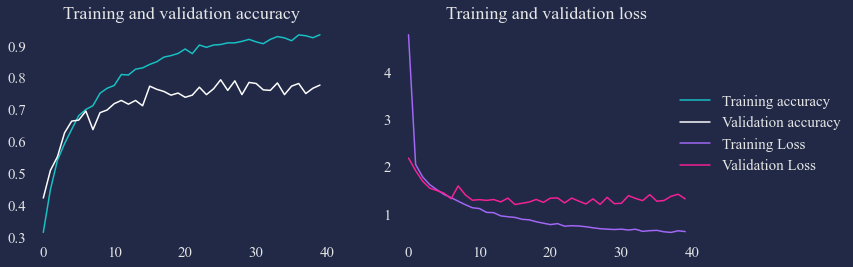

In [16]:
model = CNN_model(input_shape)

model.compile(optimizer = tf.keras.optimizers.RMSprop(learning_rate=0.005),
              loss='sparse_categorical_crossentropy',
              metrics = ['acc'])

history = model.fit(X_train, Y_train, validation_data=(X_val, Y_val), 
                    epochs=40, batch_size=32)

performance_plot(history)

Проверяем модель на тестовой выборке, строим матрицу ошибок и выводим показатели метрик

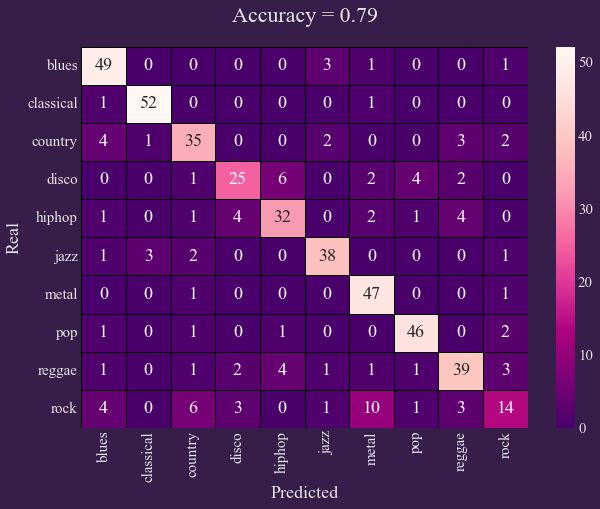

Показатели метрик
 accuracy:	 0.7854
       f1:	 0.7761
   recall:	 0.7854
precision:	 0.7776


In [17]:
prediction = model.predict(X_test, verbose=0)
Y_pred = np.argmax(prediction, axis=1)

metrics = {' accuracy' : accuracy_score(Y_test, Y_pred), 
           '       f1' : f1_score(Y_test, Y_pred, average='weighted'), 
           '   recall' : recall_score(Y_test, Y_pred, average='weighted'), 
           'precision' : precision_score(Y_test, Y_pred, average='weighted')}

confusion_martix_plot(Y_test, Y_pred, acc=metrics[' accuracy'], model_type='CNN', save=False)

print('Показатели метрик')
for metric, value in metrics.items():
    print(f'{metric}:\t \033[1m{value:.4f}\033[0m') 

Выводим сводную информацию о нейронной сети:

In [18]:
model.summary(line_length=90)

Model: "sequential_10"
__________________________________________________________________________________________
 Layer (type)                           Output Shape                        Param #       
 conv1d_30 (Conv1D)                     (None, 21, 128)                     384           
                                                                                          
 max_pooling1d_30 (MaxPooling1D)        (None, 21, 128)                     0             
                                                                                          
 conv1d_31 (Conv1D)                     (None, 20, 128)                     32896         
                                                                                          
 max_pooling1d_31 (MaxPooling1D)        (None, 20, 128)                     0             
                                                                                          
 dropout_20 (Dropout)                   (None, 20, 128)            

## <span style="font-family:Times New Roman">2\. RNN (Recurrent Neural Network)</span> 
Функция `RNN_model` содержит архитектуру RNN-модели:

In [19]:
def RNN_model(input_shape):

    model = tf.keras.models.Sequential([
        tf.keras.layers.LSTM(64, return_sequences=True, input_shape=input_shape),
        tf.keras.layers.Dropout(0.2),
        
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(10, activation='softmax')
    ])

    return model

### <span style="font-family:Times New Roman">Компилируем и обучаем модель</span> 
* Оптимизатор: **RMSprop**, learning rate = $1e-2$
* Функция потерь (Loss function): **SparseCategoricalCrossentropy**  – для двух и более классов целовчисленных меток
* Количество эпох: **30**
* Размер батча: **32**
* Для каждой эпохи рассчитывается `loss`, `accuracy` для обучающей и валидационных выборок 

Epoch 1/30
60/60 [==============================] - 2s 12ms/step - loss: 1.5120 - acc: 0.4552 - val_loss: 1.2897 - val_acc: 0.5117
Epoch 2/30
60/60 [==============================] - 0s 6ms/step - loss: 1.1832 - acc: 0.5823 - val_loss: 1.0749 - val_acc: 0.6133
Epoch 3/30
60/60 [==============================] - 0s 6ms/step - loss: 1.0482 - acc: 0.6135 - val_loss: 0.9683 - val_acc: 0.6450
Epoch 4/30
60/60 [==============================] - 0s 6ms/step - loss: 0.9546 - acc: 0.6542 - val_loss: 0.9518 - val_acc: 0.6517
Epoch 5/30
60/60 [==============================] - 0s 6ms/step - loss: 0.9117 - acc: 0.6786 - val_loss: 0.9790 - val_acc: 0.6300
Epoch 6/30
60/60 [==============================] - 0s 6ms/step - loss: 0.8610 - acc: 0.6891 - val_loss: 0.8828 - val_acc: 0.6833
Epoch 7/30
60/60 [==============================] - 0s 6ms/step - loss: 0.8194 - acc: 0.7052 - val_loss: 0.8534 - val_acc: 0.6883
Epoch 8/30
60/60 [==============================] - 0s 6ms/step - loss: 0.7679 - acc: 0.7

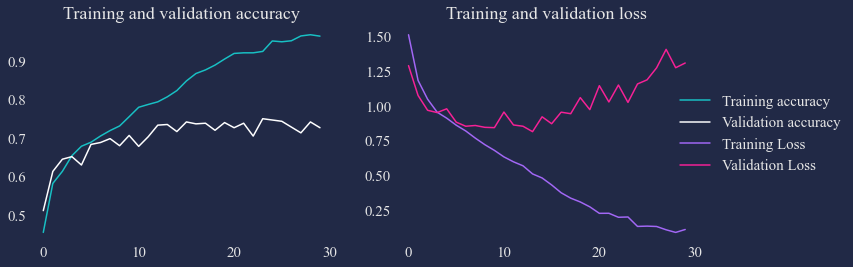

In [20]:
model = RNN_model(input_shape)

model.compile(optimizer = tf.keras.optimizers.RMSprop(learning_rate=0.01),
              loss='sparse_categorical_crossentropy',
              metrics = ['acc'])

history = model.fit(X_train, Y_train, validation_data=(X_val, Y_val), epochs=30, batch_size=32)

performance_plot(history)

Проверяем модель на тестовой выборке, строим матрицу ошибок и выводим показатели метрик

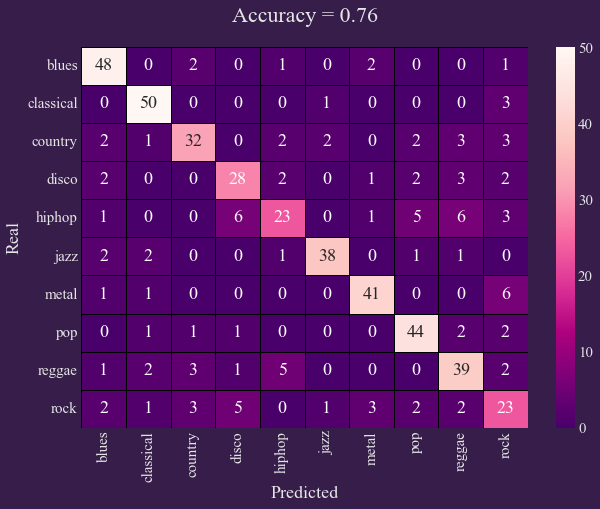

Показатели метрик
 accuracy:	 0.7625
       f1:	 0.7603
   recall:	 0.7625
precision:	 0.7624


In [21]:
prediction = model.predict(X_test, verbose=0)
Y_pred = np.argmax(prediction, axis=1)

metrics = {' accuracy' : accuracy_score(Y_test, Y_pred), 
           '       f1' : f1_score(Y_test, Y_pred, average='weighted'), 
           '   recall' : recall_score(Y_test, Y_pred, average='weighted'), 
           'precision' : precision_score(Y_test, Y_pred, average='weighted')}

confusion_martix_plot(Y_test, Y_pred, acc=metrics[' accuracy'], model_type='RNN', save=False)

print('Показатели метрик')
for metric, value in metrics.items():
    print(f'{metric}:\t \033[1m{value:.4f}\033[0m') 

Выводим сводную информацию о нейронной сети:

In [37]:
model.summary(line_length=90)

Model: "sequential_4"
__________________________________________________________________________________________
 Layer (type)                           Output Shape                        Param #       
 lstm_3 (LSTM)                          (None, 22, 64)                      16896         
                                                                                          
 dropout_7 (Dropout)                    (None, 22, 64)                      0             
                                                                                          
 flatten_4 (Flatten)                    (None, 1408)                        0             
                                                                                          
 dense_6 (Dense)                        (None, 10)                          14090         
                                                                                          
Total params: 30,986
Trainable params: 30,986
Non-trainable params: 

## <span style="font-family:Times New Roman">3\. Multilayer Perceptron</span> 
Функция `Perceptron_model` содержит архитектуру многослойного перцептрона:

In [25]:
def Perceptron_model(input_shape):

    model = tf.keras.models.Sequential([
        tf.keras.layers.Dense(units=256, activation='relu', input_shape=input_shape),
        tf.keras.layers.Dense(units=128, activation='relu'),
        tf.keras.layers.Dense(units=64, activation='relu'),
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(units=128, activation='relu'),
        tf.keras.layers.Dense(units=10, activation='softmax')
    ])
    
    return model

### <span style="font-family:Times New Roman">Компилируем и обучаем модель</span> 
* Оптимизатор: **adam**
* Функция потерь (Loss function): **SparseCategoricalCrossentropy**  – для двух и более классов целовчисленных меток
* Количество эпох: **25**
* Размер батча: **32**
* Для каждой эпохи рассчитывается `loss`, `accuracy` для обучающей и валидационных выборок 

Epoch 1/25
60/60 [==============================] - 1s 7ms/step - loss: 1.5530 - acc: 0.4573 - val_loss: 1.1937 - val_acc: 0.5783
Epoch 2/25
60/60 [==============================] - 0s 4ms/step - loss: 1.0677 - acc: 0.6182 - val_loss: 1.0461 - val_acc: 0.6017
Epoch 3/25
60/60 [==============================] - 0s 4ms/step - loss: 0.9414 - acc: 0.6635 - val_loss: 0.9777 - val_acc: 0.6567
Epoch 4/25
60/60 [==============================] - 0s 4ms/step - loss: 0.8563 - acc: 0.6865 - val_loss: 0.9217 - val_acc: 0.6667
Epoch 5/25
60/60 [==============================] - 0s 4ms/step - loss: 0.7936 - acc: 0.7172 - val_loss: 0.8862 - val_acc: 0.6700
Epoch 6/25
60/60 [==============================] - 0s 4ms/step - loss: 0.7423 - acc: 0.7339 - val_loss: 0.8799 - val_acc: 0.6917
Epoch 7/25
60/60 [==============================] - 0s 4ms/step - loss: 0.6698 - acc: 0.7677 - val_loss: 0.8601 - val_acc: 0.6983
Epoch 8/25
60/60 [==============================] - 0s 4ms/step - loss: 0.6018 - acc: 0.79

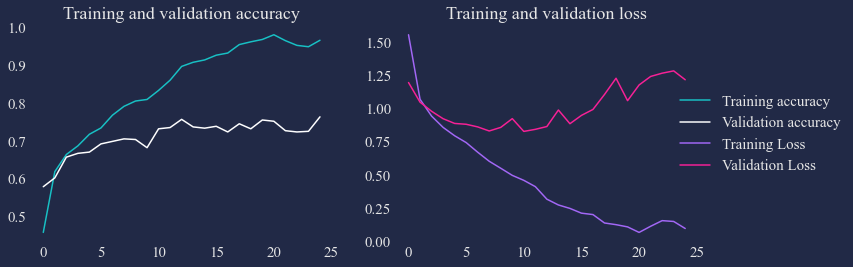

In [28]:
model = Perceptron_model(input_shape)

model.compile(optimizer = 'adam',
              loss='sparse_categorical_crossentropy',
              metrics = ['acc'])

history = model.fit(X_train, Y_train, validation_data=(X_val, Y_val),
                    epochs=25, batch_size=32)

performance_plot(history)

Проверяем модель на тестовой выборке, строим матрицу ошибок и выводим показатели метрик

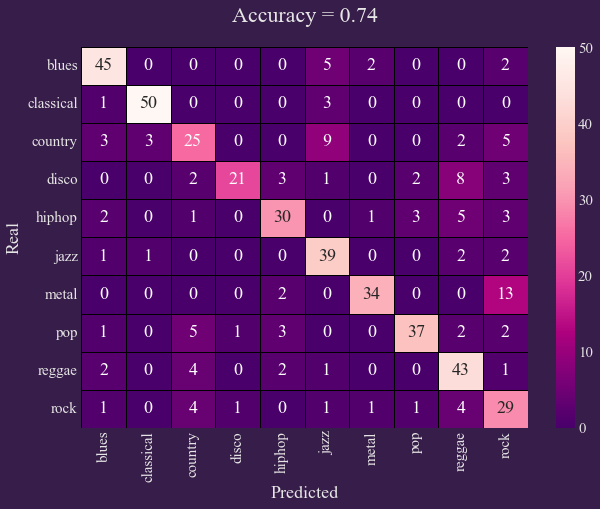

Показатели метрик
 accuracy:	 0.7354
       f1:	 0.7369
   recall:	 0.7354
precision:	 0.7596


In [31]:
prediction = model.predict(X_test, verbose=0)
Y_pred = np.argmax(prediction, axis=1)

metrics = {' accuracy' : accuracy_score(Y_test, Y_pred), 
           '       f1' : f1_score(Y_test, Y_pred, average='weighted'), 
           '   recall' : recall_score(Y_test, Y_pred, average='weighted'), 
           'precision' : precision_score(Y_test, Y_pred, average='weighted')}

confusion_martix_plot(Y_test, Y_pred, acc=metrics[' accuracy'], model_type='Perceptron', save=False)

print('Показатели метрик')
for metric, value in metrics.items():
    print(f'{metric}:\t \033[1m{value:.4f}\033[0m') 

Выводим сводную информацию о нейронной сети:

In [32]:
model.summary(line_length=90)

Model: "sequential_33"
__________________________________________________________________________________________
 Layer (type)                           Output Shape                        Param #       
 dense_88 (Dense)                       (None, 22, 256)                     512           
                                                                                          
 dense_89 (Dense)                       (None, 22, 128)                     32896         
                                                                                          
 dense_90 (Dense)                       (None, 22, 64)                      8256          
                                                                                          
 flatten_33 (Flatten)                   (None, 1408)                        0             
                                                                                          
 dense_91 (Dense)                       (None, 128)                